In [1]:
from o2s.models.object_2_sphere import Mesh2Sphere
from o2s.datasets.radar_dataset import RadarDataset
from o2s.datasets.transforms.general import Compose
from o2s.datasets.transforms.radar import Log, Abs, Normalize, Center
from o2s.datasets.transforms.mesh import MeshNormalize

import numpy as np
import matplotlib.pyplot as plt
from torch_harmonics import plotting
from torch_geometric.loader import DataLoader
import xarray
import torch
from torch import nn

In [2]:
transforms = Compose([Abs(), Log()]) 
dataset = RadarDataset('/home/colin/hdd/workspace/datasets/test_dataset.nc', 'test', 'simple', 'full', transforms=transforms, return_mesh=True)

In [3]:
B = 1
dataloader = DataLoader(dataset, batch_size=B, shuffle=True)

In [4]:
model = Mesh2Sphere(5, 25, 128, 10.0, use_mlp=True).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/

In [5]:
for batch in dataloader:
    mesh, resp, vert, face = batch
    
    for iter in range(200):
        pred, _ = model(mesh.cuda())
        target = resp[:,53].cuda()
        weight = nn.functional.softmax(target, dim=1)
        loss = weight * (pred - target) ** 2
        loss = loss.sum().mean()
        #loss = (y_pred - target.view(1,61,21).cuda()).pow(2).mean()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if iter % 10 == 0:
            print(f'iteration: {iter} loss: {loss.item()}')
    break

/media/colin/workspace/forward_fourier_model/o2s/datasets/radar_dataset.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  response = torch.tensor(torch.view_as_real(data.data)[:, :, :, 0]).permute(


iteration: 0 loss: 0.024360008537769318
iteration: 10 loss: 0.0157008059322834
iteration: 20 loss: 0.009570570662617683
iteration: 30 loss: 0.006399580277502537
iteration: 40 loss: 0.004222543444484472
iteration: 50 loss: 0.0033993155229836702
iteration: 60 loss: 0.0029059946537017822
iteration: 70 loss: 0.0028238329105079174
iteration: 80 loss: 0.0027738597709685564
iteration: 90 loss: 0.002734939567744732
iteration: 100 loss: 0.00269913487136364
iteration: 110 loss: 0.0026700287126004696
iteration: 120 loss: 0.0026494679041206837
iteration: 130 loss: 0.0026055106427520514
iteration: 140 loss: 0.0025730563793331385
iteration: 150 loss: 0.0025379029102623463
iteration: 160 loss: 0.002504476811736822
iteration: 170 loss: 0.0024610282853245735
iteration: 180 loss: 0.002405998297035694
iteration: 190 loss: 0.0023506279103457928


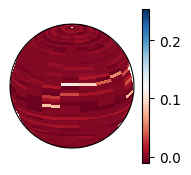

In [6]:
with torch.no_grad():
    pred, w = model(mesh.cuda())
    plotting.plot_spherical_fn(pred.cpu().squeeze().numpy(), fig=plt.figure(figsize=(2,2)))

frame=0
frame=10
frame=20
frame=30
frame=40
frame=50
frame=60
frame=70
frame=80
frame=90
frame=100
frame=110
frame=120
frame=130
frame=140
frame=150
frame=160
frame=170
frame=180
frame=190
frame=200
frame=210
frame=220
frame=230
frame=240
frame=250
frame=260
frame=270
frame=280
frame=290
frame=300
frame=310
frame=320
frame=330
frame=340
frame=350


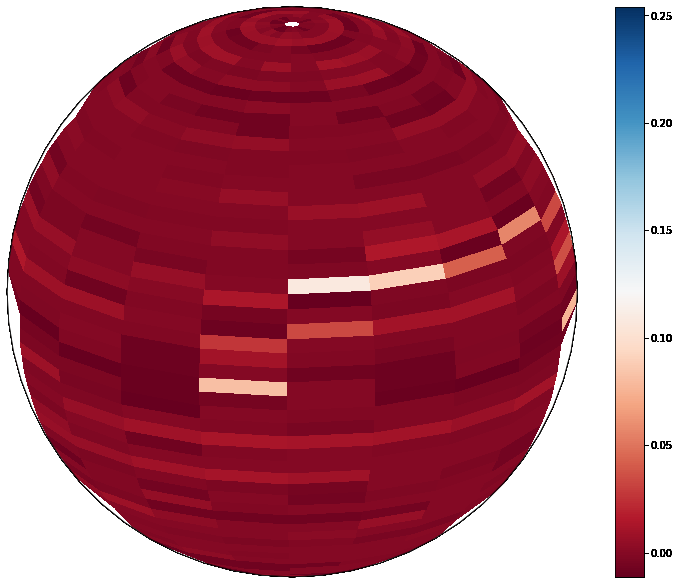

In [7]:
import matplotlib.animation as animation

fig = plt.figure(layout='constrained', figsize=(12, 8), dpi=72)

moviewriter = animation.writers['pillow'](fps=30)
moviewriter.setup(fig, 'pred.gif', dpi=72)

num_frames = 360
for frame in range(num_frames):
    # compute the rotation of the sphere
    lon = -num_frames - (360 / num_frames) * frame

    if frame % 10 == 0:
        print(f"frame={frame}")
    
        plotting.plot_spherical_fn(pred.cpu().squeeze().numpy(), fig=fig, central_longitude=lon)

    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()

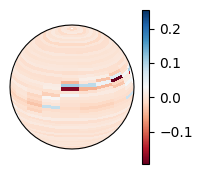

In [8]:
plotting.plot_spherical_fn(target.cpu().squeeze().numpy(), fig=plt.figure(figsize=(2,2)))

In [ ]:
fig = plt.figure(layout='constrained', figsize=(12, 8), dpi=72)

moviewriter = animation.writers['pillow'](fps=30)
moviewriter.setup(fig, 'target.gif', dpi=72)

num_frames = 360
for frame in range(num_frames):
    # compute the rotation of the sphere
    lon = -num_frames - (360 / num_frames) * frame

    if frame % 10 == 0:
        print(f"frame={frame}")
    
        plotting.plot_spherical_fn(target.cpu().squeeze().numpy(), fig=fig, central_longitude=lon)

    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()

frame=0
frame=10
frame=20
frame=30
frame=40
frame=50
frame=60
frame=70
frame=80
frame=90
frame=100
frame=110
frame=120
frame=130
frame=140
frame=150
frame=160
frame=170
frame=180
frame=190


In [ ]:
plotting.plot_spherical_fn(np.abs(target.cpu().squeeze().numpy() - pred.cpu().squeeze().numpy()), fig=plt.figure(figsize=(2,2)))

In [ ]:
fig = plt.figure(layout='constrained', figsize=(12, 8), dpi=72)

moviewriter = animation.writers['pillow'](fps=30)
moviewriter.setup(fig, 'error.gif', dpi=72)

num_frames = 360
for frame in range(num_frames):
    # compute the rotation of the sphere
    lon = -num_frames - (360 / num_frames) * frame

    if frame % 10 == 0:
        print(f"frame={frame}")
    
        plotting.plot_spherical_fn(np.abs(target.cpu().squeeze().numpy() - pred.cpu().squeeze().numpy()), fig=fig, central_longitude=lon)

    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()

In [ ]:
import trimesh
tr_mesh = trimesh.Trimesh(vertices=vert[0], faces=face[0], process=True, validate=False)
tr_mesh.show()